First attempt at prediction of price direction using technical indicators as inputs to a MLP neural network.

In [212]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from ib_async import *

In [213]:
def get_price_data(symbol, start = "2024-01-01" , end = "2024-12-01"):
    data = yf.download(symbol, start = start, end = end)
    if data.empty:
        print('No data pulled')
    else:
        return data
    

In [214]:
data = get_price_data('NVDA')

[*********************100%%**********************]  1 of 1 completed


In [215]:
close_prices = data['Close']

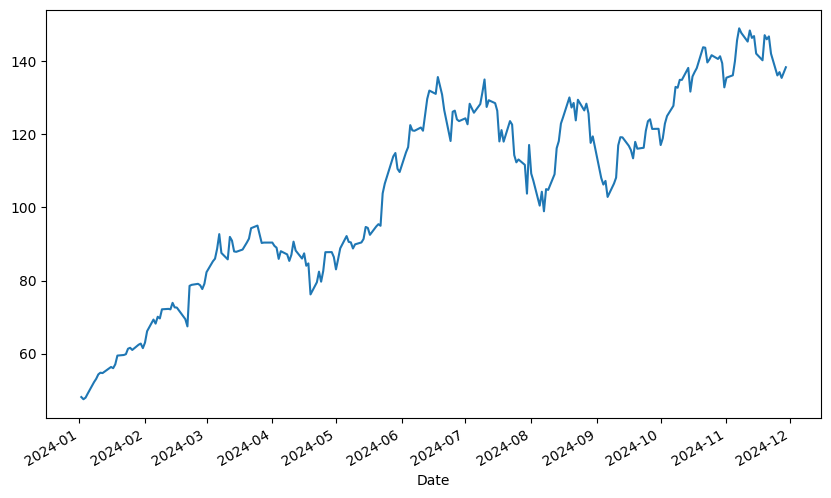

In [216]:
close_prices.plot(figsize = (10,6))
plt.show()

In [217]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(close_prices, maxlag = None, autolag = 'BIC')

adf_test

print(f" P - value of null of non-stationarity :  {adf_test[1]}")

# Note that the closing price data is non-stationary, we have insufficient evidence to reject the null hypothesis that the price series of Nvidia is non-stationary.

 P - value of null of non-stationarity :  0.39034106202762336


While we do not use OLS to estimate regression coefficients and hypothesis tests in deep learning, which will become spurious with a non-stationary time series. A point made by Ernest Chan is that price evolution/ non-stationarity of the price series means that it is difficult for the machine learning algorithm to generalise onto test data. How can the algorithm predict price direction when the price is at a new high never before seen. Thus we must have stationary data.

In [218]:
data = {"close" : close_prices,
        "log_returns" : np.log(close_prices / close_prices.shift(1))
        }

df = pd.DataFrame(data)
df.dropna(inplace=True)


In [219]:
df

,close,log_returns
Date,,
2024-01-03,47.569000,-0.012514
2024-01-04,47.998001,0.008978
2024-01-05,49.097000,0.022639
2024-01-08,52.252998,0.062299
2024-01-09,53.139999,0.016833
...,...,...
2024-11-22,141.949997,-0.032710
2024-11-25,136.020004,-0.042673
2024-11-26,136.919998,0.006595


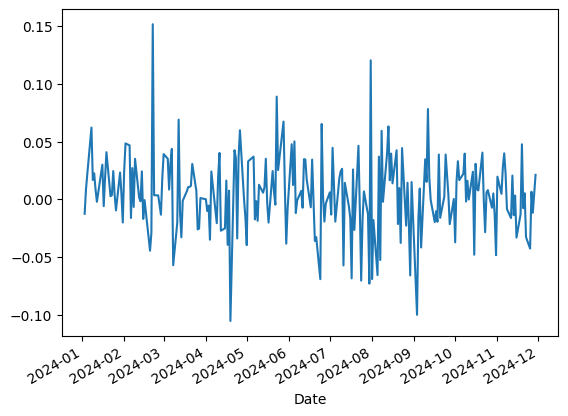

P-value for adfuller on logged returns: 1.6359327917128486e-29


In [220]:
df['log_returns'].plot()
plt.show()

log_stationarity = adfuller(df['log_returns'], maxlag= None, autolag= 'BIC')
print(f"P-value for adfuller on logged returns: {log_stationarity[1]}")

Logged returns are stationary, which is more suitable for prediction.

In [221]:
features = []

df["previous_day_return"] = df['log_returns'].shift(1)

df["average_returns_5d"] = df['log_returns'].rolling(5).mean()

df["average_returns_10d"] = df['log_returns'].rolling(10).mean()

df.dropna(inplace=True)
df

,close,log_returns,previous_day_return,average_returns_5d,average_returns_10d
Date,,,,,
2024-01-17,56.053001,-0.005852,0.030103,0.010674,0.015160
2024-01-18,57.106998,0.018629,-0.005852,0.009896,0.018275
2024-01-19,59.491001,0.040898,0.018629,0.016347,0.021467
2024-01-22,59.653999,0.002736,0.040898,0.017303,0.019476
2024-01-23,59.873001,0.003664,0.002736,0.012015,0.013613
...,...,...,...,...,...
2024-11-22,141.949997,-0.032710,0.005332,-0.000042,-0.003923
2024-11-25,136.020004,-0.042673,-0.032710,-0.005982,-0.006572
2024-11-26,136.919998,0.006595,-0.042673,-0.014221,-0.007977


In [222]:
# Model
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras import Sequential
from tensorflow.keras.losses import BinaryCrossentropy

In [223]:
model = Sequential([
            Dense(units = 64, activation = 'relu', input_shape = (3,)),
            Dense(units = 64, activation = 'relu'),
            Dense(units = 1, activation = 'sigmoid')
])

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = BinaryCrossentropy(from_logits = True))

model.summary()

c:\Users\George Bresnahan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_27 (Dense)                │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,481 (17.50 KB)

 Trainable params: 4,481 (17.50 KB)

 Non-trainable params: 0 (0.00 B)

In [224]:
from sklearn.model_selection import train_test_split

df['return_direction'] = np.where(df['log_returns'] > 0, 1, 0)

X = df.iloc[:,2:5]
Y = df['return_direction']

x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size= 0.25, shuffle = False)


In [225]:
model.fit(x_train, y_train, epochs = 500, validation_split = 0.2, shuffle = False, verbose = False)  

# outputs the probability that the return for that day is positive given the features

c:\Users\George Bresnahan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\nn.py:750: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
c:\Users\George Bresnahan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\nn.py:750: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


In [226]:
df

,close,log_returns,previous_day_return,average_returns_5d,average_returns_10d,return_direction
Date,,,,,,
2024-01-17,56.053001,-0.005852,0.030103,0.010674,0.015160,0
2024-01-18,57.106998,0.018629,-0.005852,0.009896,0.018275,1
2024-01-19,59.491001,0.040898,0.018629,0.016347,0.021467,1
2024-01-22,59.653999,0.002736,0.040898,0.017303,0.019476,1
2024-01-23,59.873001,0.003664,0.002736,0.012015,0.013613,1
...,...,...,...,...,...,...
2024-11-22,141.949997,-0.032710,0.005332,-0.000042,-0.003923,0
2024-11-25,136.020004,-0.042673,-0.032710,-0.005982,-0.006572,0
2024-11-26,136.919998,0.006595,-0.042673,-0.014221,-0.007977,1


In [227]:
pred = np.where(model.predict(x_test) > 0.6, 1, 0) # predicts it is more likely to be positive


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


In [228]:
df_test = df.loc[y_test.index]

df_test['prediction'] = np.where(pred > 0, 1, -1)

In [229]:
df_test['strategy_returns'] = (df_test['prediction'] * df_test['log_returns'])

df_test[['log_returns', 'strategy_returns']].sum().apply(np.exp)

log_returns         1.182534
strategy_returns    1.578763
dtype: float64

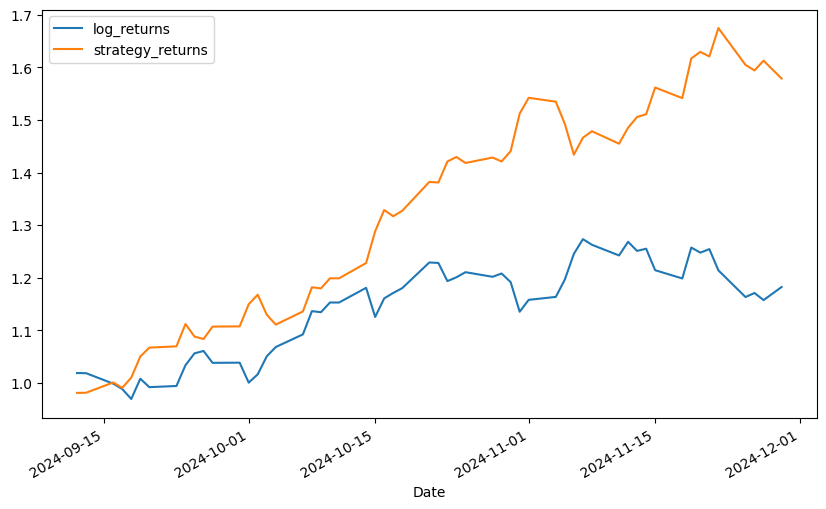

In [230]:
df_test[['log_returns', 'strategy_returns']].cumsum().apply(np.exp).plot(figsize = (10,6))
plt.show()